In [1]:
import torch, pickle, argparse, os
import importlib
from fig_settings import *
from util import *
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import numpy as np

In [2]:
run_id = 'material_model_run_m1'

CKPT_PATH = run_id+ '/vmm-epoch=1999-train_rel_error=0.0000.ckpt'
checkpoint = torch.load(CKPT_PATH, map_location='cpu')

/var/folders/sw/6bcl4ngj0x77mrv5p1s62_k00000gn/T/ipykernel_63298/1840446607.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH, map_locati

In [3]:
params = torch.load(run_id+'/args.pkl', weights_only=True)
args = argparse.Namespace(**params)  
folder = f'overleaf/figs/{run_id}' 
if not os.path.exists(folder):
    os.makedirs(folder)

In [4]:
mm = importlib.import_module(run_id + '.' + args.material_model)
from util import LossFunction
from m_encoder import *
from lightning_script import *
device = torch.device(args.device if torch.cuda.is_available() else "cpu")
    )

In [7]:
encoder_input_dim = 501
ae_E = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
ae_nu = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
energy_input_dim = (1, args.niv, args.encoder_latent_dim * 2)
energy_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(","))
    )
dissipation_input_dim = energy_input_dim  # (p_dim, q_dim, m_dim)
dissipation_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(",")))
ae_E.freeze_encoder()
ae_nu.freeze_encoder()

vmm = mm.ViscoelasticMaterialModel(
    energy_input_dim,
    energy_hidden_dim,
    dissipation_input_dim,
    dissipation_hidden_dim,
    ae_E.encoder,
    ae_nu.encoder,
    dt = args.step/5000.0
).to(device)

<class 'list'> <class 'list'>
30 100


In [9]:
lit = LitVMM.load_from_checkpoint(checkpoint_path=CKPT_PATH, model=vmm, name="vmm_", loss_type="mse")

In [10]:
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

data_file = args.data_path
content = open(data_file, "r").read().strip()
data_files = [file.strip() for file in content.split("\n")]
# data_files = [file.strip() for file in data_file.split(",")]
# print(data_files)

datasets = [
    ViscoelasticDataset(
        data_path=file,
        step=args.step,
        device=device,
        encoder=False,
    )
    for file in data_files
]
dataset = ConcatDataset(datasets)
length = len(dataset)

trainset = Subset(dataset, args.train_indices)
valset = Subset(dataset, args.val_indices)
testset = Subset(dataset, args.test_indices)
loss_function = LossFunction()

In [11]:
tempset = testset
indices = args.test_indices

In [12]:
dataloader = DataLoader(
        tempset, batch_size=len(tempset), shuffle=False, num_workers=0
    )
s_pred = []
s_true = []
for batch in dataloader:
    x, y = batch
    s, xi = vmm(*x)
    loss = np.asarray(list(map(lambda l: l.item(), loss_function.L2RelativeError(s, y, reduction=None))))
    s_true.append(y.cpu())
    s_pred.append(s.cpu().detach())
s_true = torch.cat(s_true, dim=0)
s_pred = torch.cat(s_pred, dim=0)

In [13]:
sorted_indices = np.argsort(indices)

In [14]:
l_infty = []
for i in range(len(tempset)):
    x, y = tempset[i]
    l_infty.append(torch.max(torch.abs(y)).item())

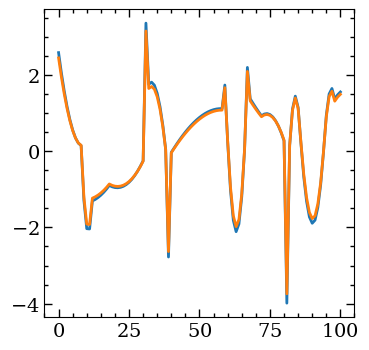

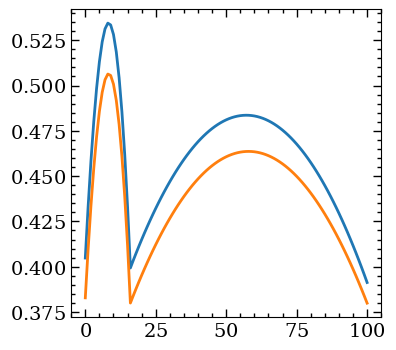

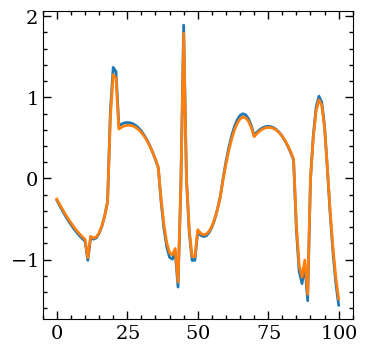

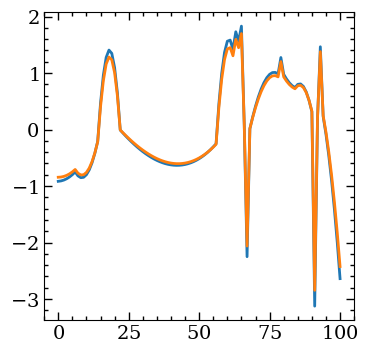

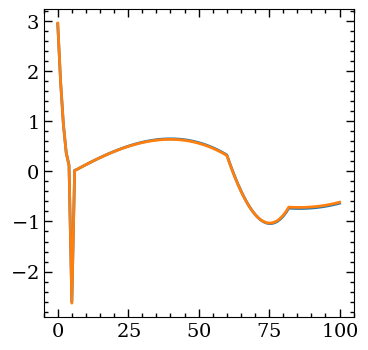

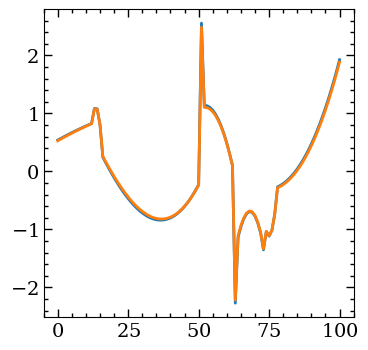

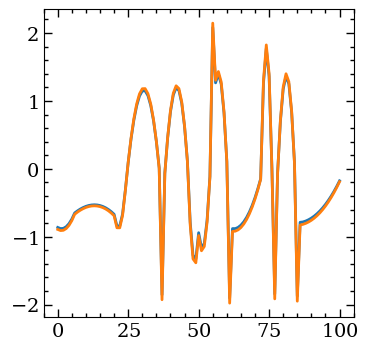

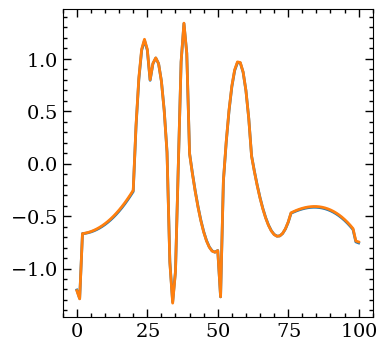

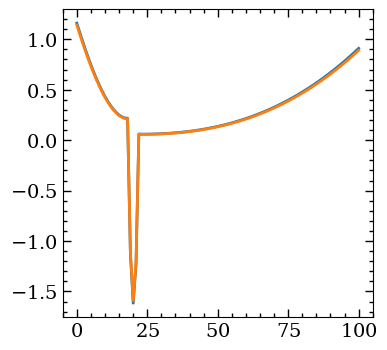

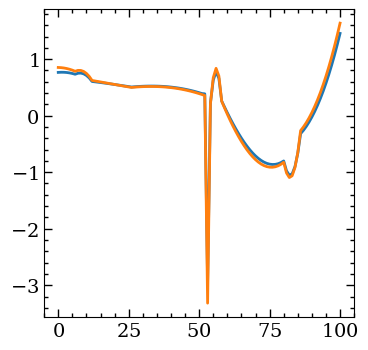

In [15]:
for i in range(10):
    plt.figure(figsize=(4,4))
    plt.plot(tempset[sorted_indices[-i]][1][:,0])
    plt.plot(s_pred[sorted_indices[-i]][:,0].detach().cpu())
    plt.show()

In [16]:
data0 = pickle.load(open(data_files[0], 'rb'))
data1 = pickle.load(open(data_files[1], 'rb'))
data2 = pickle.load(open(data_files[2], 'rb'))
data3 = pickle.load(open(data_files[3], 'rb'))

In [17]:
data_map = {0: data0, 1: data1, 2: data2, 3: data3}
elastic_norm = []
viscous_norm = []
memory_norm = []
total_norm = []
for i in range(4):
    data = data_map[i]
    elastic = data['E_prime']*data0['strain'][:,::50,:] 
    viscous = data['nu_prime']*data0['strain_rate'][:,::50,:]
    memory = data['stress'][:,::50,:] - elastic - viscous
    elastic_norm.append(np.max(np.abs(elastic), axis=1))
    viscous_norm.append(np.max(np.abs(viscous), axis=1))
    memory_norm.append(np.max(np.abs(memory), axis=1))
    total_norm.append(np.max(np.abs(data['stress'][:,::50,:]), axis=1))
memory_norm = np.concatenate(memory_norm).squeeze()
elastic_norm = np.concatenate(elastic_norm).squeeze()
viscous_norm = np.concatenate(viscous_norm).squeeze()
total_norm = np.concatenate(total_norm).squeeze()

memory_norm = memory_norm[indices]
elastic_norm = elastic_norm[indices]
viscous_norm = viscous_norm[indices]
total_norm = total_norm[indices]
    

Text(0.5, 0, 'Relative Error')

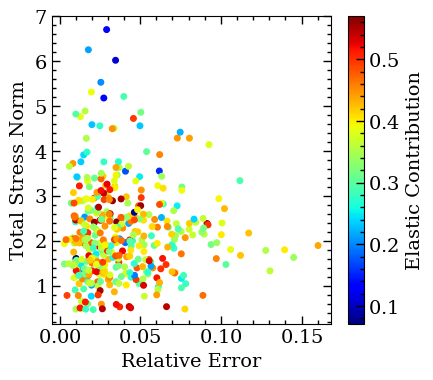

In [18]:
plt.scatter(loss, total_norm, c=elastic_norm, cmap='jet')
plt.colorbar(label='Elastic Contribution')
plt.ylabel('Total Stress Norm')
plt.xlabel('Relative Error')


Text(0.5, 0, 'Relative Error')

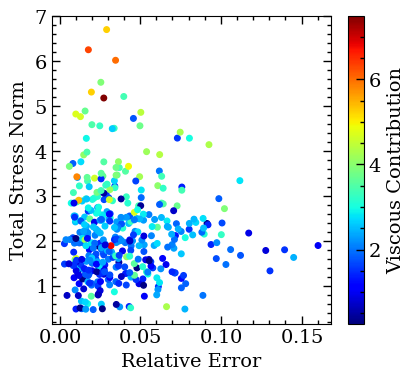

In [19]:
plt.scatter(loss, total_norm, c=viscous_norm, cmap='jet')
plt.colorbar(label='Viscous Contribution')
plt.ylabel('Total Stress Norm')
plt.xlabel('Relative Error')

Text(0.5, 0, 'Relative Error')

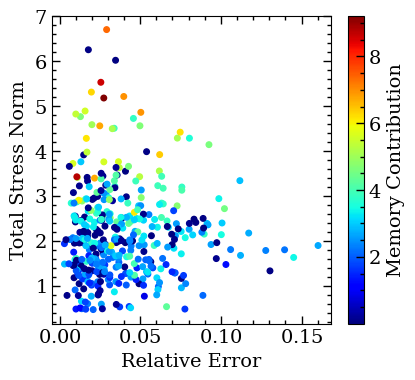

In [20]:
plt.scatter(loss, total_norm, c=memory_norm, cmap='jet')
plt.colorbar(label='Memory Contribution')
plt.ylabel('Total Stress Norm')
plt.xlabel('Relative Error')

<ErrorbarContainer object of 3 artists>

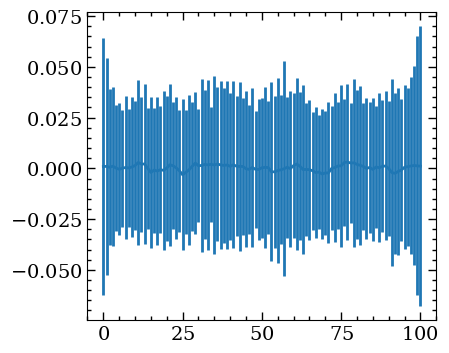

In [21]:
error = s_pred - s_true
error_mean = torch.mean(error, dim=0).squeeze().numpy()
error_std = torch.std(error, dim=0).squeeze().numpy()
plt.errorbar(range(error_mean.shape[0]), error_mean, yerr=error_std)


In [22]:
s_perd_new = s_pred - np.expand_dims(error_mean, axis=-1)
loss_function.L2RelativeError(s_perd_new, s_true), loss_function.L2RelativeError(s_pred, s_true)

(tensor(0.0388), tensor(0.0388))

In [ ]:
data_map = {0: data0, 1: data1, 2: data2, 3: data3}
E0, E0_true = [], []
nu0, nu0_true = [], []
A= []
BbyA = []
for i in range(4):
    data = data_map[i]
    E0_true.append(data['E_prime'])
    E0.append(data['E_prime'])
    m_features = torch.cat([vmm.E_encoder(torch.tensor(data['E'], dtype=torch.float32)), vmm.E_encoder(torch.tensor(data['nu'], dtype=torch.float32))], axis=1)
memory_norm = np.concatenate(memory_norm).squeeze()
elastic_norm = np.concatenate(elastic_norm).squeeze()
viscous_norm = np.concatenate(viscous_norm).squeeze()
total_norm = np.concatenate(total_norm).squeeze()

In [ ]:
data['E'].shape, vmm.E_encoder(torch.tensor(data['E'], dtype=torch.float32)), data['E_prime'].shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x15 and 30x100)

In [35]:
vmm.energy_function.E0().shape

torch.Size([1000, 1])